In [1]:
#Installing required libraries
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q quanto
!pip install -q langchain_community
!pip -q install langchain

!pip install -q -U google-generativeai
!pip install -q streamlit

!pip install -q sentence-transformers
!pip install -q faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 72.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 8.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.0/974.0 kB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [5]:
import pathlib
import textwrap
import google.generativeai as genai

from IPython.display import display
from IPython.display import Markdown
import PIL.Image
import os

from langchain_community.llms.huggingface_pipeline import HuggingFacePipeline
from transformers import AutoModelForCausalLM, AutoTokenizer, QuantoConfig, pipeline
from huggingface_hub import login

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains.question_answering import load_qa_chain
from langchain_core.prompts import PromptTemplate

import streamlit as st
from PIL import Image
import io
import re

os.getenv('GOOGLE_API_KEY') #removed API Key
genai.configure(api_key="GOOGLE_API_KEY")
hf_token ="HUGGING_FACE_API_KEY"
hf_token = login(hf_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [10]:
#Multi model(text-images-audio) gemini-1.5-flash - Using it for Image to text
gemini_model = genai.GenerativeModel('gemini-1.5-flash')

#llama2 chat hf Quantized Model
model_id = "meta-llama/Llama-2-7b-chat-hf"

quantization_config = QuantoConfig(load_in_8bit_fp32_cpu_offload=True)

llma2_model = AutoModelForCausalLM.from_pretrained(model_id,
                                             device_map="auto",
                                             quantization_config=quantization_config)

llma2_tokenizer = AutoTokenizer.from_pretrained(model_id)

#sentence-transformer embedding
modelPath = "sentence-transformers/all-MiniLM-l6-v2"
model_kwargs = {'device':'cpu'}
encode_kwargs = {'normalize_embeddings': False}
embeddings = HuggingFaceEmbeddings(
    model_name=modelPath,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# **Graph Summarization**


---






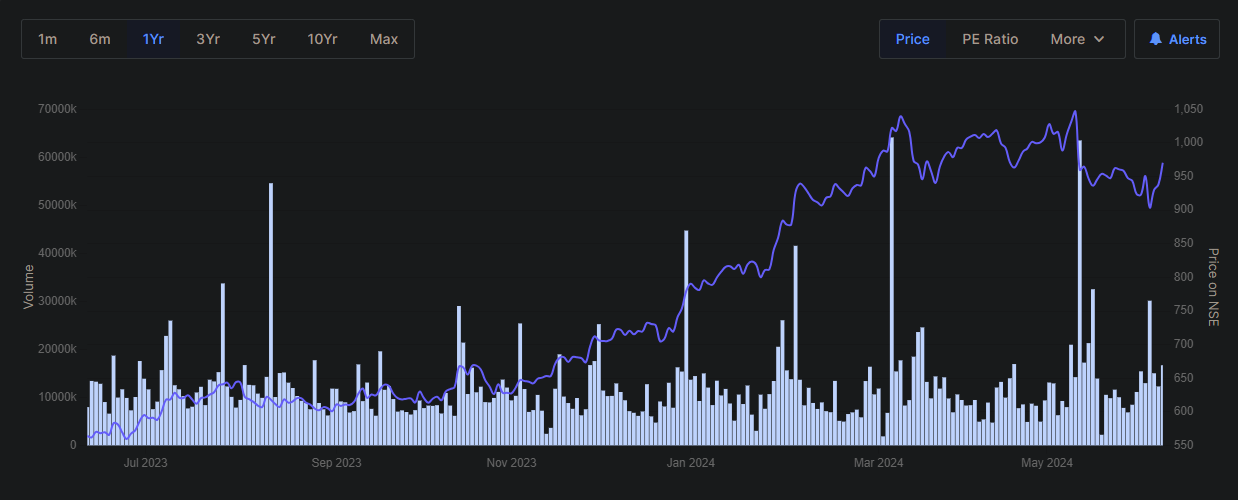

In [3]:
#Loading Image
img = PIL.Image.open('/content/tamo.png')
img

In [7]:
def to_markdown(text):
  #Show Generated Text
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

#prompt to generate summarization
prompt = """
Please analyze the given graph in detail.

Your explanation should include:
- The title and context of the graph.
- A description of the x-axis and y-axis, including their labels and units.
- The key trends, patterns, and significant data points.
- Any anomalies or outliers present in the graph.
- A summary of what the graph indicates and its implications.

Ensure the explanation is comprehensive, between 800-1200 words, and includes specific examples and data points from the graph to support your analysis.

"""

response =gemini_model.generate_content([prompt, img], stream=True)
response.resolve()
to_markdown(response.text)

> The graph depicts the price and volume of a stock traded on the National Stock Exchange of India (NSE) over a period of one year. 
> 
> The x-axis represents the date, spanning from July 2023 to May 2024. The y-axis on the left represents the volume of shares traded, measured in thousands (k). The y-axis on the right represents the price of the stock on the NSE, measured in Indian rupees.
> 
> The graph shows a positive trend in both the price and volume of the stock. The price has been steadily increasing over the past year, with a significant jump in March 2024. The volume of shares traded has also been increasing, particularly in September 2023, January 2024, and March 2024, indicating high interest in the stock. 
> 
> Here are some key observations:
> 
> * **Price Trend:** The stock price has experienced a general upward trend over the past year, indicating strong investor confidence. It started at around 600 rupees in July 2023 and reached a peak of over 1,000 rupees in March 2024 before dipping slightly. 
> * **Volume Trend:** The volume of shares traded shows a positive correlation with the price. There were significant spikes in volume during September 2023, January 2024, and March 2024, coinciding with periods of price increase. These periods suggest heightened investor activity and potentially news-driven market movement.
> * **Significant Data Points:**
>     * **September 2023:** The stock price experienced a sharp increase, reaching almost 700 rupees, coinciding with a huge surge in volume exceeding 500,000 shares traded. This suggests a major market event, such as the release of positive earnings reports or a significant corporate announcement.
>     * **January 2024:** Another significant increase in volume, surpassing 400,000 shares traded, coincides with a modest price increase to around 800 rupees. While not as dramatic as the September spike, it still highlights a period of heightened activity.
>     * **March 2024:** The most significant increase in both volume and price occurred in March 2024. The volume reached nearly 700,000 shares traded, and the price skyrocketed past 1,000 rupees, indicating a very strong bullish sentiment and high investor demand.
> * **Anomalies and Outliers:** The volume spikes in September 2023, January 2024, and March 2024 stand out as outliers compared to the generally lower trading volume on other days. These spikes are significant because they occur during periods of strong price increases, highlighting periods of major market activity.
> 
> The graph indicates that the stock has been performing well in the market, with increasing price and volume. The strong upward trend in price, particularly during the March 2024 surge, suggests a bullish market sentiment and strong investor confidence in the company's future prospects. 
> 
> However, it is important to consider that past performance is not indicative of future results. Factors like market conditions, economic developments, and company performance can all influence future stock price movements. It's crucial for investors to conduct thorough research and consider various factors before making investment decisions.
> 
> The graph does not provide information about the specific company or its financial performance, so further investigation is needed to understand the underlying reasons for the stock's positive trend. Examining factors like earnings reports, corporate announcements, industry trends, and overall market conditions can provide a more complete understanding of the stock's performance.


In [12]:
#saving generated text in text file
with open("01.txt", "w") as file:
    file.write(response.text)

#download text file
file_path = "01.txt"
with open(file_path, "r") as file:
    text = file.read()

# Question & Answer Using RAG

---



In [15]:
#hugging face Pipeline
pipe = pipeline("text-generation", model=llma2_model, tokenizer=llma2_tokenizer, max_new_tokens=250)
hf = HuggingFacePipeline(pipeline=pipe)

#using whole text as single chunk size (becuase )
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=1000)

text_chunks = text_splitter.split_text(text)
vector_store = FAISS.from_texts(text_chunks, embedding=embeddings)

In [20]:
#similarity search
user_question ="what is trend of graph"
docs = vector_store.similarity_search(user_question)
print(docs)

[Document(page_content="The graph indicates that the stock has been performing well in the market, with increasing price and volume. The strong upward trend in price, particularly during the March 2024 surge, suggests a bullish market sentiment and strong investor confidence in the company's future prospects. \n\nHowever, it is important to consider that past performance is not indicative of future results. Factors like market conditions, economic developments, and company performance can all influence future stock price movements. It's crucial for investors to conduct thorough research and consider various factors before making investment decisions."), Document(page_content='The graph depicts the price and volume of a stock traded on the National Stock Exchange of India (NSE) over a period of one year. \n\nThe x-axis represents the date, spanning from July 2023 to May 2024. The y-axis on the left represents the volume of shares traded, measured in thousands (k). The y-axis on the righ

In [21]:
#Creating llm chain

def extract_answer(text):
    #Disply only Output text
    match = re.search(r'Answer:(.*?)(?=Explanation:|$)', text, re.DOTALL)
    if match:
        return match.group(1).strip()
    else:
        return "The answer is not available in the context."

prompt_template = """
Answer the question as thoroughly as possible based on the provided context.
Ensure to include all relevant details.
If the answer cannot be determined from the provided context,
simply state, "The answer is not available in the context."
Avoid providing incorrect answers.

Context:
{context}

Question:
{question}

Answer:
"""
prompt = PromptTemplate(template = prompt_template, input_variables = ["context", "question"])

chain = load_qa_chain(hf, chain_type="stuff", prompt=prompt)

In [22]:
# user_question ="what is value of catogary B"
user_question ="what is trend of graph"
docs = vector_store.similarity_search(user_question)

response = chain(
        {"input_documents":docs, "question": user_question}
        , return_only_outputs=True)

{'output_text': '\nAnswer the question as thoroughly as possible based on the provided context.\nEnsure to include all relevant details.\nIf the answer cannot be determined from the provided context,\nsimply state, "The answer is not available in the context."\nAvoid providing incorrect answers.\n\nContext:\nThe graph indicates that the stock has been performing well in the market, with increasing price and volume. The strong upward trend in price, particularly during the March 2024 surge, suggests a bullish market sentiment and strong investor confidence in the company\'s future prospects. \n\nHowever, it is important to consider that past performance is not indicative of future results. Factors like market conditions, economic developments, and company performance can all influence future stock price movements. It\'s crucial for investors to conduct thorough research and consider various factors before making investment decisions.\n\nThe graph depicts the price and volume of a stock 

In [23]:
ans = extract_answer(response["output_text"])
print(ans)

Based on the provided graph, the trend of the stock price over the past year is generally upward, indicating strong investor confidence and a bullish market sentiment. The price started at around 600 rupees in July 2023 and reached a peak of over 1,000 rupees in March 2024 before dipping slightly. However, it is important to note that past performance is not indicative of future results, and various factors like market conditions, economic developments, and company performance can influence future stock price movements.


In [25]:
def chatbot_response(user_question):

    docs = vector_store.similarity_search(user_question)
    response = chain(
            {"input_documents":docs, "question": user_question}
            , return_only_outputs=True)

    output = extract_answer(response["output_text"])
    return f"{output}"

Chatbot for Given Graph

---



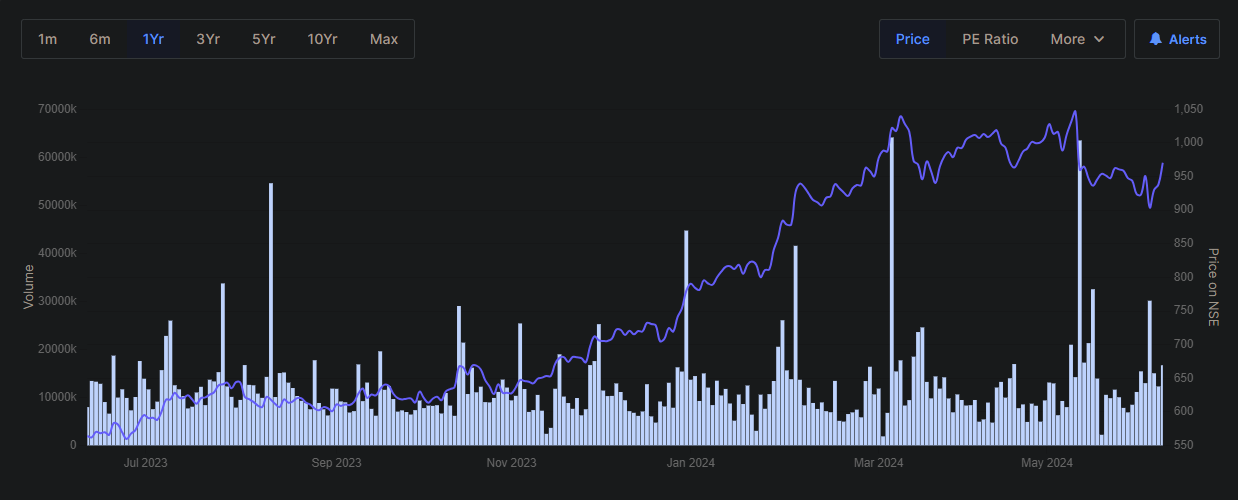

In [28]:
img = PIL.Image.open('/content/tamo.png')
img

In [27]:
def chat():
    print("Welcome to the chatbot! Type 'exit' to stop.")
    while True:
        user_question = input("You: ")
        if user_question.lower() == 'exit':
            print("Goodbye...!")
            break
        response = chatbot_response(user_question)
        print(f"Chatbot: {response}")

# Start the chat
chat()

Welcome to the chatbot! Type 'exit' to stop.
You: what is trend of graph
Chatbot: Based on the provided graph, the trend of the stock price over the past year is generally upward, indicating a bullish market sentiment and strong investor confidence in the company's future prospects. The price started at around 600 rupees in July 2023 and reached a peak of over 1,000 rupees in March 2024 before dipping slightly. However, it is important to consider that past performance is not indicative of future results, and various factors can influence future stock price movements.
You: what is trend in March 2024 as compare to july 2023
Chatbot: Based on the provided context, the trend in March 2024 compared to July 2023 is:

* **Price Trend:** The price in March 2024 (around 1,000 rupees) is significantly higher than in July 2023 (around 600 rupees), indicating a strong bullish sentiment and high investor demand.

Therefore, the answer is:

The price in March 2024 is significantly higher than in J